# Content Based 3d Model Retrieval

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

##### Handling OFF file format

http://www.geomview.org/docs/html/OFF.html

# Preprocess the data

In [1]:
import binvox_rw_py as binvox
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

with open('ModelNet10/chair/train/chair_0001.binvox', 'rb') as f:
    model = binvox.read_as_3d_array(f)

# with open('sample.binvox', 'rb') as f:
#     model = binvox.read_as_3d_array(f)

##### plotting voxels in matplotlib

In [6]:
x, y, z = np.indices(model.data.shape)

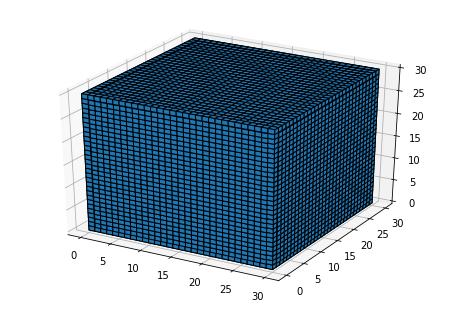

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# model.data is a 3D boolean array in this case. Probably could also be float array.
fig = plt.figure()
ax = Axes3D(fig)
ax.voxels(model.data, edgecolor='k');

# Evaluate class balance for ModelNet10 and ModelNet40

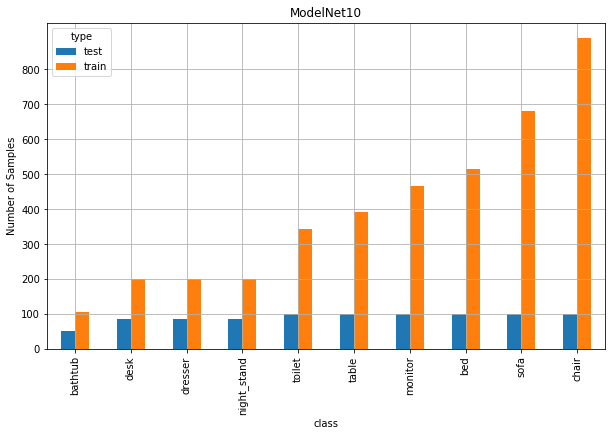

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


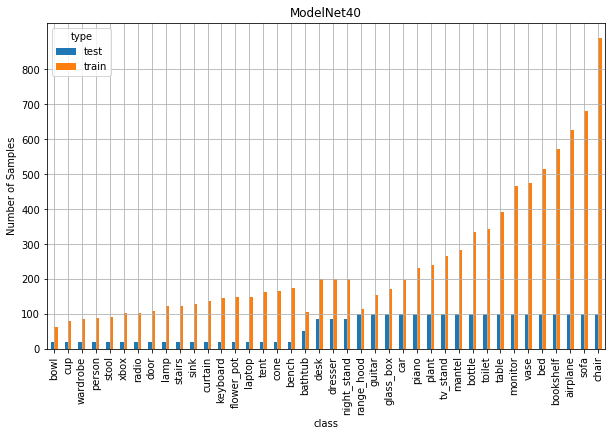

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_class_balance)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_class_balance(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_class_balance(df, 'ModelNet40')

# Appendix:

In [2]:
import numpy as np